# CNN with cats and dogs

In [1]:
### credit to nicknochnack

In [2]:
import sys
import os
import kagglehub
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from matplotlib import pyplot as plt

# Check if you're in the correct virtual environment
print(f"Using Python executable: {sys.executable}")

# Suppress TensorFlow informational messages for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/home/phil/projects/cats-vs-dogs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-17 16:55:23.147664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using Python executable: /home/phil/projects/cats-vs-dogs/bin/python


# Load data

In [3]:

# 1. Define the destination folder name
destination_folder = "images"
os.makedirs(destination_folder, exist_ok=True) # Ensure the folder exists

print("Step 1: Downloading dataset to the local cache...")

# 2. Download the full dataset to the default cache location
# Do NOT use the 'path' argument here.
# The function will return the path to the unzipped files in the cache.
source_path = kagglehub.dataset_download(
    "samuelcortinhas/cats-and-dogs-image-classification"
)

print(f"   > Download complete. Cached at: {source_path}")
print("\nStep 2: Copying files to the 'images' folder...")

# 3. Copy the entire directory from the cache to your destination folder
# shutil.copytree is perfect for copying a whole folder and its contents.
# dirs_exist_ok=True prevents an error if you run the script a second time.
shutil.copytree(source_path, destination_folder, dirs_exist_ok=True)

print(f"✅ Dataset successfully copied to: {os.path.abspath(destination_folder)}")

Step 1: Downloading dataset to the local cache...
   > Download complete. Cached at: /home/phil/.cache/kagglehub/datasets/samuelcortinhas/cats-and-dogs-image-classification/versions/4

Step 2: Copying files to the 'images' folder...
✅ Dataset successfully copied to: /home/phil/GitLab/cats-vs-dogs/images


In [4]:
# --- UPDATED PATHS ---
# This dataset has a different folder structure.
train_dir = os.path.join( 'images', 'train')
test_dir = os.path.join('images', 'test')

# Verify that the paths exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Training directory not found at: {train_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Validation directory not found at: {test_dir}")

print(f"Training data path: {train_dir}")
print(f"Validation data path: {test_dir}")

Training data path: images/train
Validation data path: images/test


\n--- Analyzing Data Distribution ---
Training set contains: 279 cats and 278 dogs.
Test set contains:     70 cats and 70 dogs.


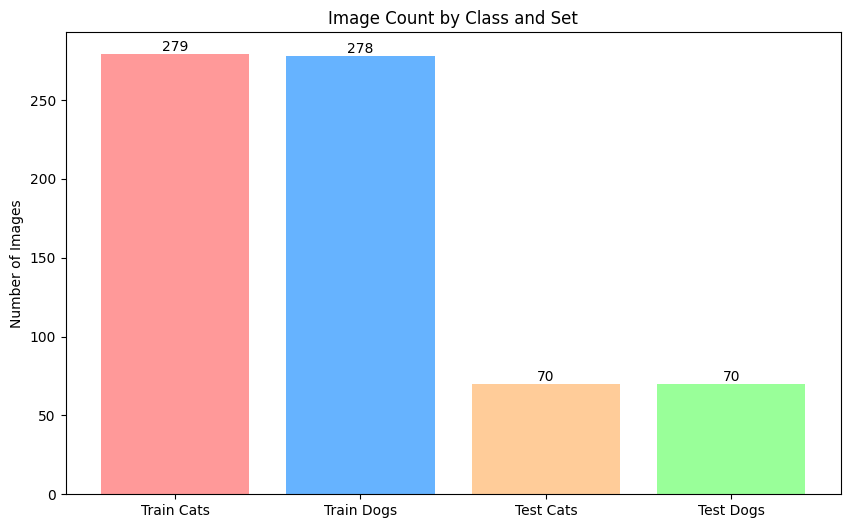

In [5]:
# =======================================================
# 3. COUNT AND VISUALIZE DATA DISTRIBUTION
# =======================================================
print("\n--- Analyzing Data Distribution ---")
try:
    num_train_cats = len(os.listdir(os.path.join(train_dir, 'cats')))
    num_train_dogs = len(os.listdir(os.path.join(train_dir, 'dogs')))
    num_test_cats = len(os.listdir(os.path.join(test_dir, 'cats')))
    num_test_dogs = len(os.listdir(os.path.join(test_dir, 'dogs')))

    print(f"Training set contains: {num_train_cats} cats and {num_train_dogs} dogs.")
    print(f"Test set contains:     {num_test_cats} cats and {num_test_dogs} dogs.")

    labels = ['Train Cats', 'Train Dogs', 'Test Cats', 'Test Dogs']
    counts = [num_train_cats, num_train_dogs, num_test_cats, num_test_dogs]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color=['#ff9999', '#66b3ff', '#ffcc99', '#99ff99'])
    plt.title('Image Count by Class and Set')
    plt.ylabel('Number of Images')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')
    
    plt.show()

except FileNotFoundError:
    print("Could not find cat/dog subdirectories. Please check the dataset structure.")



In [11]:
# =======================================================
# 4. PREPARE, SCALE, AND OPTIMIZE DATASETS (Corrected)
# =======================================================
print("\n--- Preparing, Scaling, and Optimizing Datasets ---")

image_size = (256, 256)
batch_size = 32

# Load the raw training data FIRST to get the class names
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.02,
    subset='training',
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)
# NOW, grab the class_names attribute from the raw dataset
class_names = raw_train_ds.class_names
print(f"✅ Class names captured: {class_names}")

# Load the other raw datasets
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.02,
    subset='validation',
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

# Define the scaling function and performance optimizer
def scale_data(image, label):
    return image / 255.0, label

AUTOTUNE = tf.data.AUTOTUNE

# THEN, apply the map, cache, and prefetch transformations
train_ds = raw_train_ds.map(scale_data).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.map(scale_data).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.map(scale_data).cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Datasets are scaled, cached, and ready for training.")

\n--- Preparing, Scaling, and Optimizing Datasets ---
Found 557 files belonging to 2 classes.
Using 546 files for training.
✅ Class names captured: ['cats', 'dogs']
Found 557 files belonging to 2 classes.
Using 11 files for validation.
Found 140 files belonging to 2 classes.
✅ Datasets are scaled, cached, and ready for training.


\n--- Displaying a Sample of Training Images ---


2025-09-17 16:59:26.371251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


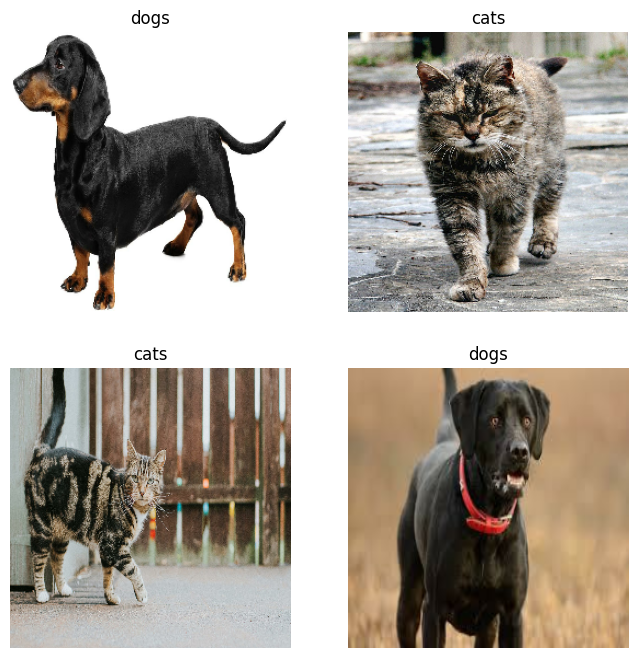

In [14]:
# =======================================================
# 5. VISUALIZE A BATCH OF SCALED DATA
# =======================================================
print("\n--- Displaying a Sample of Training Images ---")

plt.figure(figsize=(8, 8))

# Get one batch from the dataset iterator
images, labels = next(iter(train_ds))

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.show()

In [17]:
# =======================================================
# 6. BUILD A BETTER MODEL WITH TRANSFER LEARNING
# =======================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input

print("\n--- Building Model with MobileNetV2 Base ---")

# 1. Define the input shape
input_shape = (256, 256, 3)

# 2. Load the pre-trained MobileNetV2 model as a base
# We don't include the final classification layer (include_top=False)
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False, # We'll add our own classifier
    weights='imagenet'
)

# 3. Freeze the base model
# This prevents the pre-trained weights from being updated during training
base_model.trainable = False

# 4. Create the new model by adding our layers on top of the base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # A layer to average the features
    Dense(1, activation='sigmoid') # Our final binary classifier
])

# 5. Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Use a slightly lower learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()


--- Building Model with MobileNetV2 Base ---


/tmp/ipykernel_1662658/2570708260.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# =======================================================
# 7. TRAIN THE NEW MODEL
# =======================================================
print("\\n--- Starting New Model Training ---")
logdir = 'logs_mobilenet' # Use a new log directory
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, # 10 epochs is a good starting point for transfer learning
    callbacks=[tensorboard_callback]
)

print("--- New Model Training Complete ---")

\n--- Starting New Model Training ---
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9945 - loss: 0.0506 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9963 - loss: 0.0463 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9963 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9982 - loss: 0.0391 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9982 - loss: 0.0362 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9982 - loss: 0.0336 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9982 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9982 - l

\n--- Plotting Learning Curves ---


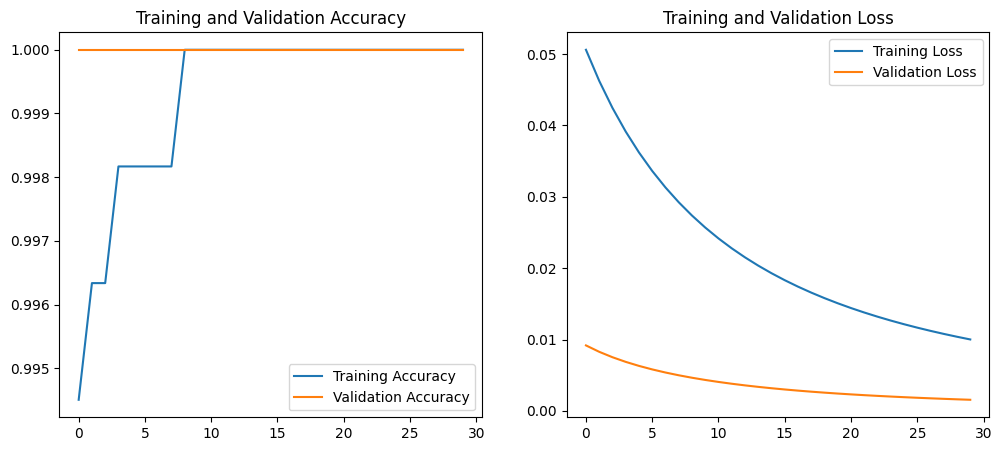

In [21]:
# =======================================================
# 8. PLOT LEARNING CURVES
# =======================================================
print("\n--- Plotting Learning Curves ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [28]:
%pip install scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


# Testing


--- Evaluating final model performance on the test set ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

--- Classification Report for Test Set ---
              precision    recall  f1-score   support

        cats       1.00      0.93      0.96        70
        dogs       0.93      1.00      0.97        70

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140


--- Generating Final Confusion Matrix Plot ---


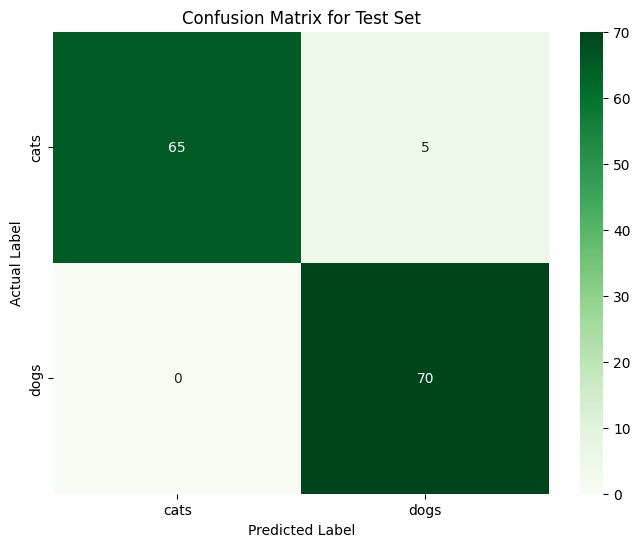

In [30]:
# =======================================================
# 8. FINAL EVALUATION ON THE TEST SET
# =======================================================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

print("\n--- Evaluating final model performance on the test set ---")

# Create empty lists to store all the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test_ds to get predictions for every image
for images, labels in test_ds:
    predictions = model.predict(images)
    # Convert the sigmoid probabilities to binary predictions (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int).flatten()
    
    # Add the results for this batch to our lists
    predicted_labels.extend(binary_predictions)
    true_labels.extend(labels.numpy().astype(int))

# Convert the lists into arrays for scikit-learn
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# --- Generate and Print Classification Report ---
print("\n--- Classification Report for Test Set ---")
# This report shows the final precision, recall, and F1-score.
print(classification_report(true_labels, predicted_labels, target_names=class_names))


# --- Generate and Plot Confusion Matrix ---
print("\n--- Generating Final Confusion Matrix Plot ---")
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# upload a photo

In [31]:
%pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]
Note: you may need to restart the kernel to use updated packages.


In [40]:
# =======================================================
# 9. TEST WITH YOUR OWN IMAGE (Final Version)
# =======================================================
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output
import numpy as np
from PIL import Image
import io

# --- Define a layout for bigger buttons ---
button_layout = Layout(width='400px', height='80px')

# --- Create the widgets using the new layout ---
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Pet Image',
    layout=button_layout
)

classify_button = widgets.Button(
    description='Classify Image',
    disabled=False,
    button_style='success',
    icon='search',
    layout=button_layout
)

output_area = widgets.Output()

# --- Define the function that runs when the button is clicked ---
def classify_image_on_click(b):
    with output_area:
        clear_output()
        if not uploader.value:
            print("Please upload an image first.")
            return
            
        print("Processing image...")
        try:
            # CORRECTED LINE: Access the file dictionary from the tuple using its index [0]
            uploaded_file = uploader.value[0] 
            content = uploaded_file['content']
            
            # 1. Preprocess the image
            img = Image.open(io.BytesIO(content))
            img_array = np.array(img)
            img_tensor = tf.convert_to_tensor(img_array)[:, :, :3]

            img_resized = tf.image.resize(img_tensor, [256, 256])
            img_scaled = img_resized / 255.0
            img_batch = tf.expand_dims(img_scaled, 0)

            # 2. Make a prediction
            print("Model is predicting...")
            prediction_score = model.predict(img_batch)[0][0]
            
            # 3. Interpret and display the result
            if prediction_score < 0.5:
                predicted_class = class_names[0]
                confidence = (1 - prediction_score) * 100
            else:
                predicted_class = class_names[1]
                confidence = prediction_score * 100

            print(f"✅ Prediction: {predicted_class}")
            
            plt.figure(figsize=(6,6))
            plt.imshow(img_array)
            plt.title(f"Model Prediction: {predicted_class} ({confidence:.1f}% confident)")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred: {e}")

# --- Link the button's on_click event to our function ---
classify_button.on_click(classify_image_on_click)

# --- Display all the widgets ---
print("Ready to classify. Upload an image, then click the button.")
display(uploader, classify_button, output_area)

Ready to classify. Upload an image, then click the button.


FileUpload(value=(), accept='image/*', description='Upload Pet Image', layout=Layout(height='80px', width='400…

Button(button_style='success', description='Classify Image', icon='search', layout=Layout(height='80px', width…

Output()